In [29]:
%%capture
!pip install selenium

In [30]:
import re
import time
import datetime
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass

In [44]:
SLEEP = 2
DEPTH = 1
URL = 'https://lenta.ru/parts/news/'
#TOPICS = ['politics', 'world', 'economy', 'society', 'incidents']

In [32]:
@dataclass
class Article:

    #id: str = None
    url: str = None
    title: str = None
    subtitle: str = None
    content: str = None
    datetime: str = None
    tag: str = None
    laughing: int = None
    thumbsup: int = None
    rage: int = None
    hearts: int = None
    thumbsdown: int = None
    cry: int = None
    exploding_head: int = None

In [60]:
# set webdriver params
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('headless')
chrome_options.add_argument('no-sandbox')
chrome_options.add_argument('disable-dev-shm-usage')
driver = webdriver.Chrome(options=chrome_options)

In [34]:
def get_pages():

    """Load and scroll pages"""
    items = []

    try:
        old_size = len(items)
        driver.get(URL)
        time.sleep(SLEEP)

        # push to list 20 next articles
        #for i in range(20):
        #  driver.execute_script("document.getElementsByClassName('loadmore')[0].click()")
        #  time.sleep(1)

        # scroll page to automatically load more articles
        for i in tqdm(range(DEPTH), leave=False):
            try:
                driver.execute_script(f'window.scrollTo(0, document.body.scrollHeight - 1200)')
                time.sleep(2)
                driver.execute_script("document.getElementsByClassName('loadmore js-loadmore')[0].click()")
                time.sleep(2)
            except:
                pass

        # find all pages
        html = driver.page_source
        soup = BeautifulSoup(html, "html.parser")
        scope = soup.find('div', {'class' : 'parts-page__wrap'})
        items += scope.find_all('li', {'class': 'parts-page__item'})

        # number of pages can not be multiple of deepth*20
        # that's why we count topics_order dynamically
        new_size = len(items)
        #if new_size > old_size:
        #    topics_order.extend([topic] * (new_size - old_size))
    except:
        pass

    #return items, topics_order
    return items

In [59]:
def parse_page(page):
    """Extract from page desired fields"""

    # Create article data class object
    article = Article()

    # article url
    article.url = page.find('a', {'class': 'card-full-news _parts-news'})['href']
    base_url = 'https://lenta.ru'
    article.url = base_url + article.url
    # article id
    #s = re.findall(r'\d+.html', article.url)[0]
    #article.id = s[ : s.find('.')]

    # load page
    driver.get(article.url)
    time.sleep(SLEEP)
    html = driver.page_source

    # article source
    source = article.url[8: article.url.find('.')]

    # article object
    soup = BeautifulSoup(html, "html.parser")
    obj = soup.find('div', {'class': 'topic-page__container'})

    #article reqaction
    smiles = ['thumbsup', 'laughing', 'rage', 'hearts', 'thumbsdown', 'cry', 'exploding_head']
    allli = obj.find_all('li', {'class': 'emoji-bar__emoji-list-item js-emoji'})
    for react in allli:
      if react.find('span', {'aria-label': f'{smiles[0]}'}) != []:
        print('its okay')
        article.thumbsup = react.find('div').text
        n = react.find('div').text
        print(f'n react_thumbsup = {n}')
      elif react.find('span', {'aria-label': f'{smiles[1]}'}) != []:
        article.laughing = react.find('div').text
        n = react.find('div').text
        print(f'n react_laughing = {n}')
      elif react.find('span', {'aria-label': f'{smiles[2]}'}) != []:
        article.rage = react.find('div').text
      elif react.find('span', {'aria-label': f'{smiles[3]}'}) != []:
        article.hearts = react.find('div').text
      elif react.find('span', {'aria-label': f'{smiles[4]}'}) != []:
        article.thumbsdown = react.find('div').text
      elif react.find('span', {'aria-label': f'{smiles[5]}'}) != []:
        article.cry = react.find('div').text
      elif react.find('span', {'aria-label': f'{smiles[6]}'}) != []:
        article.exploding_head = react.find('div').text

    # process article title
    title = obj.find('span', {'class': 'topic-body__title'})
    title_2 = obj.find('h1', {'class': 'topic-body__title'})

    if title:
        article.title = title.text
    else:
        article.title = title_2.text if title_2 else ''

    # article subtitle
    subtitle = obj.find('div', {'class': 'topic-body__title-yandex'})
    article.subtitle = subtitle.text if subtitle else ''

    # article content
    article.content = obj.find('div', {'class': 'topic-body__content'}).text

    # article tag
    article.tag = obj.find('a', {'class': 'topic-header__item topic-header__rubric'}).text

    # article datetime
    article.datetime = obj.find('a', {'class': 'topic-header__item topic-header__time'}).text

    # article number of views
    #article.views = int(obj.find('span', {'class': 'statistic__item m-views'}).text)

    return article

In [45]:
pages = get_pages()

In [47]:
print(len(pages))

41


In [61]:
# parse each page and get desired attributes
# few pages are differ significantly from others
# using try/except we can ignore them
data, topics_order_fixed = [], []
for num, page in enumerate(tqdm(pages)):
    try:
        res = parse_page(page)
        data.append(res)
        #topics_order_fixed.append(topics_order[num])
    except:
        pass

driver.close()

  5%|▍         | 2/41 [00:21<08:01, 12.34s/it]

its okay
n react_thumbsup = 5
its okay
n react_thumbsup = 0
its okay
n react_thumbsup = 0
its okay
n react_thumbsup = 0
its okay
n react_thumbsup = 0
its okay
n react_thumbsup = 0
its okay
n react_thumbsup = 0


100%|██████████| 41/41 [02:38<00:00,  3.86s/it]


MaxRetryError: HTTPConnectionPool(host='localhost', port=34721): Max retries exceeded with url: /session/7fb9862c12ad65525f04655617be997a/window (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7aeda12ebb90>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [49]:
df = pd.DataFrame(data=data)
df.head()

,url,title,subtitle,content,datetime,tag,laughing,thumbsup,rage,hearts,thumbsdown,cry,exploding_head
0,https://lenta.ru/news/2025/01/30/vozlyublennay...,Возлюбленная Джейсона Стэйтема пришла на модны...,,"Возлюбленная актера Джейсона Стэйтема, британс...","20:45, 30 января 2025",Ценности,0,None,None,None,None,None,None
1,https://lenta.ru/news/2025/01/30/glava-ofisa-z...,Глава офиса Зеленского рассказал послу Великоб...,Глава ОП Украины Ермак рассказал послу Великоб...,Глава офиса президента (ОП) Украины Владимира ...,"20:41, 30 января 2025",Бывший СССР,0,None,None,None,None,None,None
2,https://lenta.ru/news/2025/01/30/pereehavshego...,Переехавшего в Копейск итальянца депортировали...,Переехавшего в Копейск итальянца Херберта Сено...,"69-летнего итальянца Херберта Сенонера, переех...","20:40, 30 января 2025",Мир,0,None,None,None,None,None,None
3,https://lenta.ru/news/2025/01/30/nazvana-data-...,Названа дата отстыковки «Прогресса МС-28» от МКС,«Роскосмос»: Корабль «Прогресс МС-28» отстыкуе...,Транспортный грузовой корабль «Прогресс МС-28»...,"20:39, 30 января 2025",Наука и техника,0,None,None,None,None,None,None
4,https://lenta.ru/news/2025/01/30/podozrevaemom...,Подозреваемому в расправе над российским бойцо...,В Махачкале суд продлил арест подозреваемому в...,Ленинский районный суд Махачкалы продлил арест...,"20:39, 30 января 2025",Силовые структуры,0,None,None,None,None,None,None


In [13]:
print(df.shape)

(208, 7)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
df.to_pickle('df_final.p', compression='gzip')
df = pd.read_pickle('df_final.p', compression='gzip')
df.drop(columns='views', inplace=True)
df = df.reset_index(drop=True)

In [16]:
df.tag.value_counts()

,count
tag,
Экономика,40
Силовые структуры,30
Мир,29
Бывший СССР,26
Россия,23
Культура,12
Путешествия,11
Спорт,10
Ценности,9


In [17]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

In [22]:
for tag in df.tag.unique():
    words = df[df.tag == tag].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {tag} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
def data_form(date):
  date = re.sub(r",", "", date)
  date = date.split(' ')
  mounth = {'января': '01.',
            'февраля': '02.',
            'марта': '03.',
            'апреля': '04.',
            'майя': '05.',
            'июня': '06.',
            'июля': '07.',
            'августа': '08.',
            'сентября': '09.',
            'октября': '10.',
            'ноября': '11.',
            'декабря': '12.',}
  if date[2] == "января":
    date[2] = '01.'
  date[1] = date[1].join(' .')
  return ''.join(date)
df['datetime'] = df['datetime'].apply(lambda x: data_form(x))
df['datetime'] = pd.to_datetime(df.datetime)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')

<ipython-input-26-95fb5f0a2e33>:21: UserWarning: Parsing dates in %H:%M %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df.datetime)


<ipython-input-27-a389088a1d02>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
<ipython-input-27-a389088a1d02>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
<ipython-input-27-a389088a1d02>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)


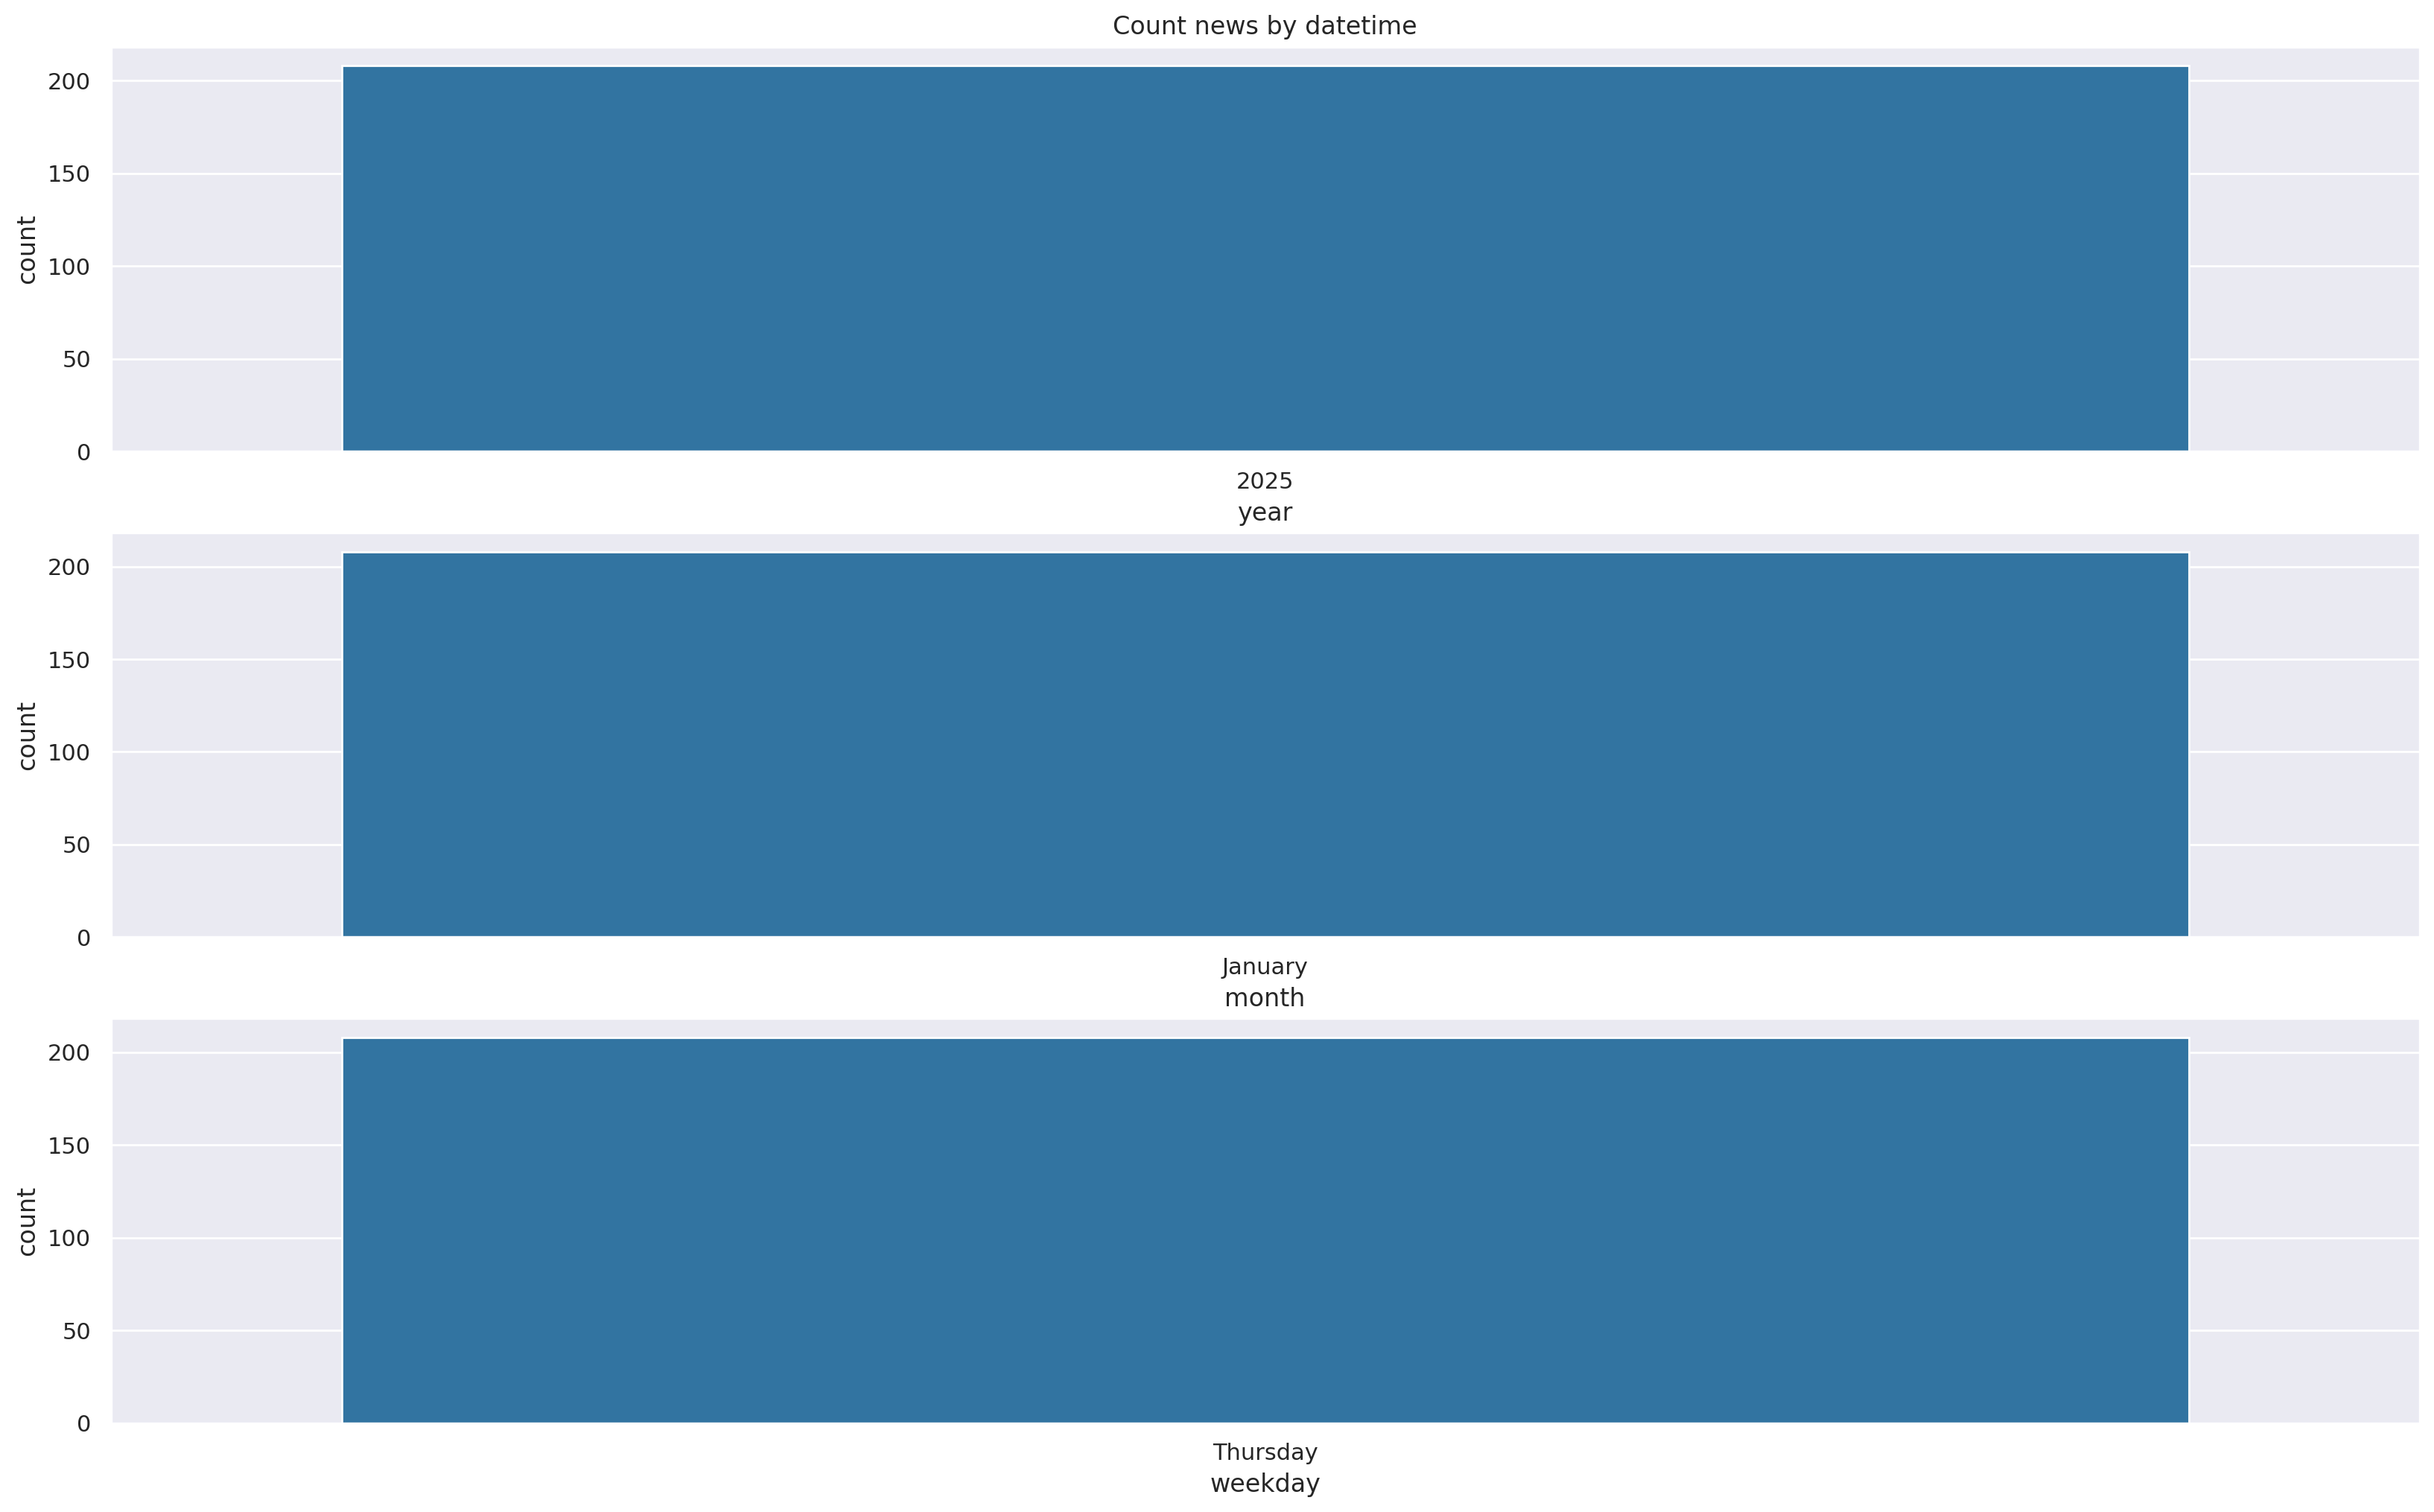

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(['year', 'month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Count news by datetime');